In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-07 17:34:30 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=1e-2,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] - model.epi for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,jp,p):
    j = str(jp)
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(j_-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(j_-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))
model.product_sum_stage_con = pe.Constraint(model.TRAY,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(model.epi.value)
    model.P_tray[j,'heavy'].fix(model.epi.value)
    
for p in m.PRODUCT:
    if p != 'naphtha' and p != 'heavy':
        model.P_tray['condenser',p].fix(model.epi.value)
        model.P_tray['reboiler',p].fix(model.epi.value)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [16]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0276          0.6495  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.9  0.000       0.000  0.000  0.000  0.000       5.7767  0.0000  0.7545  0.0000       20.000
NON--[2]     132.1  0.000       0.000  0.000  0.000  0.000       5.8817  0.0000  0.6847  0.0000       20.000
NON--[3]     141.5  0.000       0.000  0.000  0.000  0.000       5.8119  0.0000  0.6197  0.0023       20.000
NON--[4]     150.1  0.000       0.000  0.000  0.000  

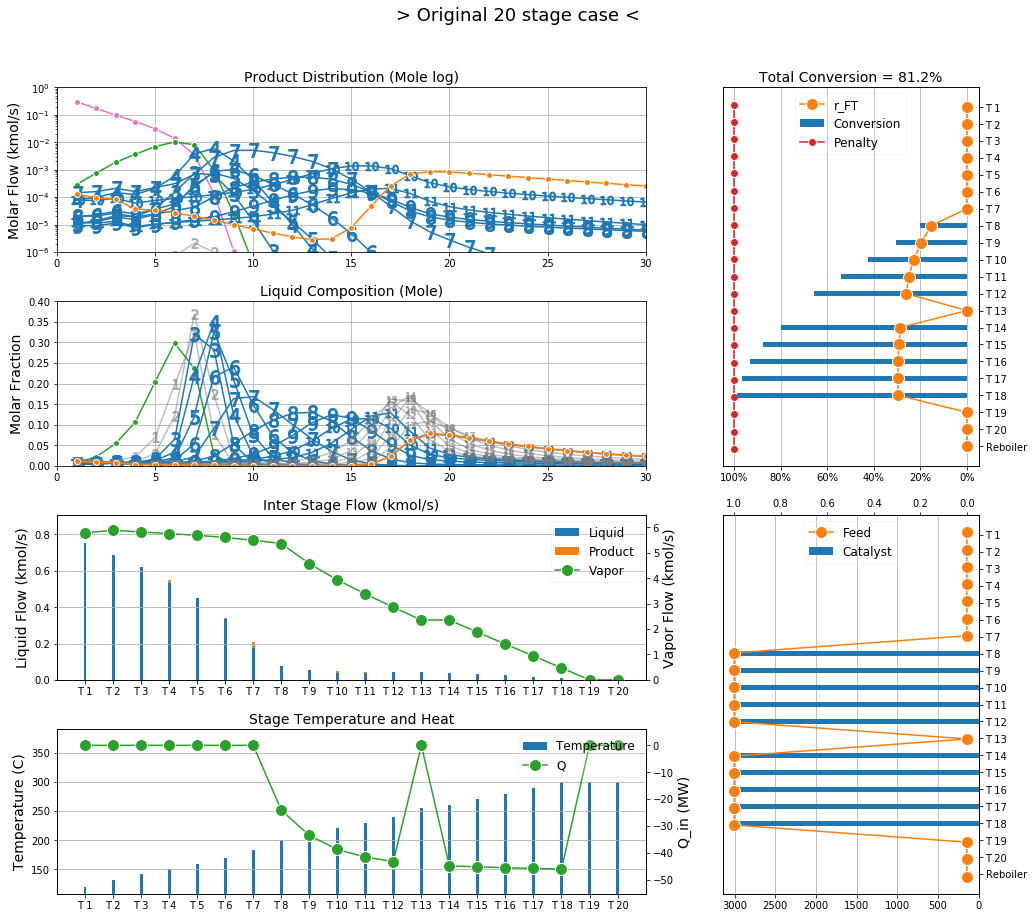

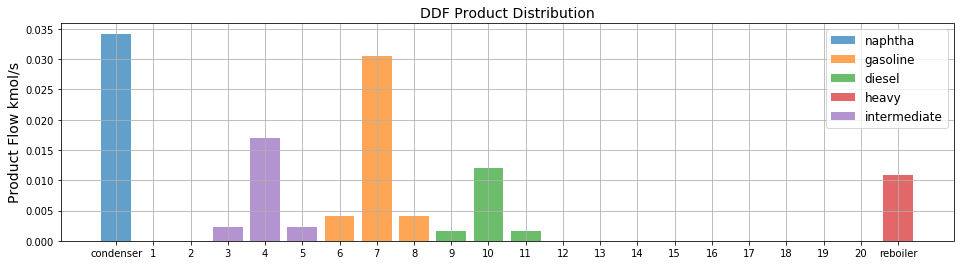

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [21]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [22]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [23]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.0352255e-01 1.09e-02 7.00e-02  -9.0 3.79e+00    -  1.00e+00 8.59e-01h  1
  66 -1.0352216e-01 3.82e-06 1.26e-05  -9.0 5.48e-01    -  1.00e+00 1.00e+00h  1
  67 -1.0352216e-01 3.00e-10 1.22e-10  -9.0 3.82e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:  -1.0352215886151345e-01   -1.0352215886151345e-01
Dual infeasibility......:   1.2228740630881657e-10    1.2228740630881657e-10
Constraint violation....:   3.0046984735368487e-10    3.0046984735368487e-10
Complementarity.........:   1.6305979150074238e-09    1.6305979150074238e-09
Overall NLP error.......:   1.6305979150074238e-09    1.6305979150074238e-09


Number of objective function evaluations             = 90
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 90
Number of inequality constraint evaluations          = 90
Number of equality constraint Jacobi


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 87.78%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1331          0.9840  0.0910       2.3314

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.2  0.000       0.000  0.000  0.000  0.000       5.5397  0.0000  1.2187  0.0000       20.000
NON--[2]     149.0  0.000       0.000  0.000  0.000  0.000       5.7744  0.0000  1.1626  0.0000       20.000
NON--[3]     160.0  0.000       0.000  0.000  0.000  0.000       5.7183  0.0000  1.1142  0.0000       20.000
NON--[4]     169.0  0.00

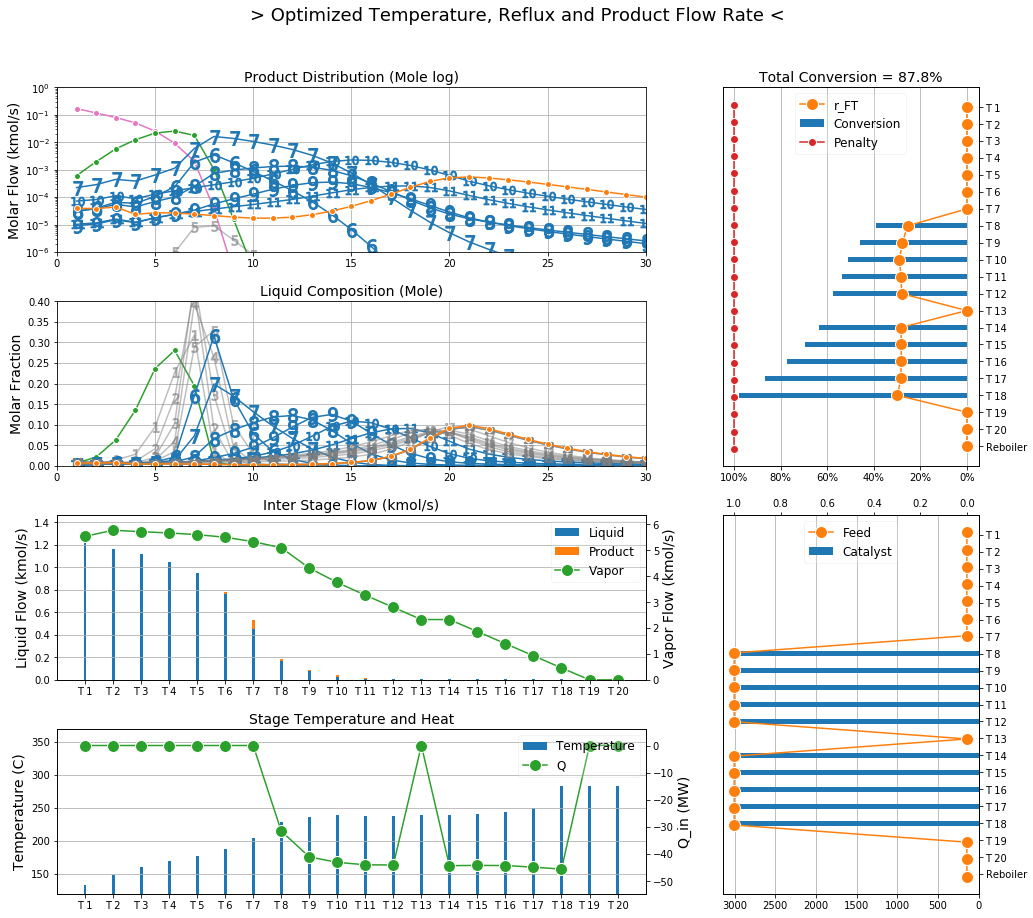

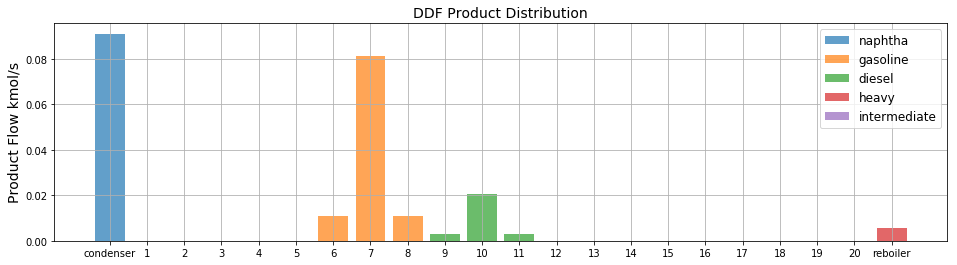

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [25]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [26]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2123439e-01 4.48e+00 6.02e+01  -6.0 1.15e+03 -10.2 8.70e-01 5.03e-01h  1
  66 -1.2154162e-01 2.26e+01 1.31e+01  -6.0 1.31e+03    -  8.72e-01 9.77e-01h  1
  67 -1.2150333e-01 7.20e+00 3.75e+00  -6.0 1.90e+02    -  1.00e+00 6.88e-01h  1
  68 -1.2144404e-01 9.46e-01 1.59e+00  -6.0 2.63e+02    -  1.00e+00 1.00e+00h  1
  69 -1.2152168e-01 2.61e+00 3.92e+00  -6.0 7.75e+02    -  2.78e-01 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2152459e-01 1.63e-01 3.52e-02  -6.0 2.66e+01    -  1.00e+00 1.00e+00h  1
  71 -1.2152919e-01 2.22e-02 6.55e-02  -6.0 2.41e+01    -  8.51e-01 1.00e+00h  1
  72 -1.2154477e-01 4.50e-01 1.29e-01  -6.0 8.14e+01  -9.7 1.00e+00 1.00e+00h  1
  73 -1.2157483e-01 4.93e-01 4.82e-01  -6.0 1.61e+02    -  1.00e+00 1.00e+00h  1
  74 -1.2163591e-01 2.63e+00 1.62e+00  -6.0 3.13e+02    -  8.38e-01 1.00e+00H  1
  75 -1.2165122e-01 1.61e-01 2.45e-01  -6.0 8.37e+01 -10.2 1.00e+00 1.00e+00h  1
  76 -1.2163820e-01 9.28e-02


> Optimized Feed Allocation
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.54%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -150.                                        1.8322          0.6303  0.0970       2.4242

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9838  0.0000  0.7431  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.0966  0.0000  0.6888  0.0000       20.000
NON--[3]     142.9  0.000       0.000  0.000  0.000  0.000       5.0424  0.0000  0.6484  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.000  0.00

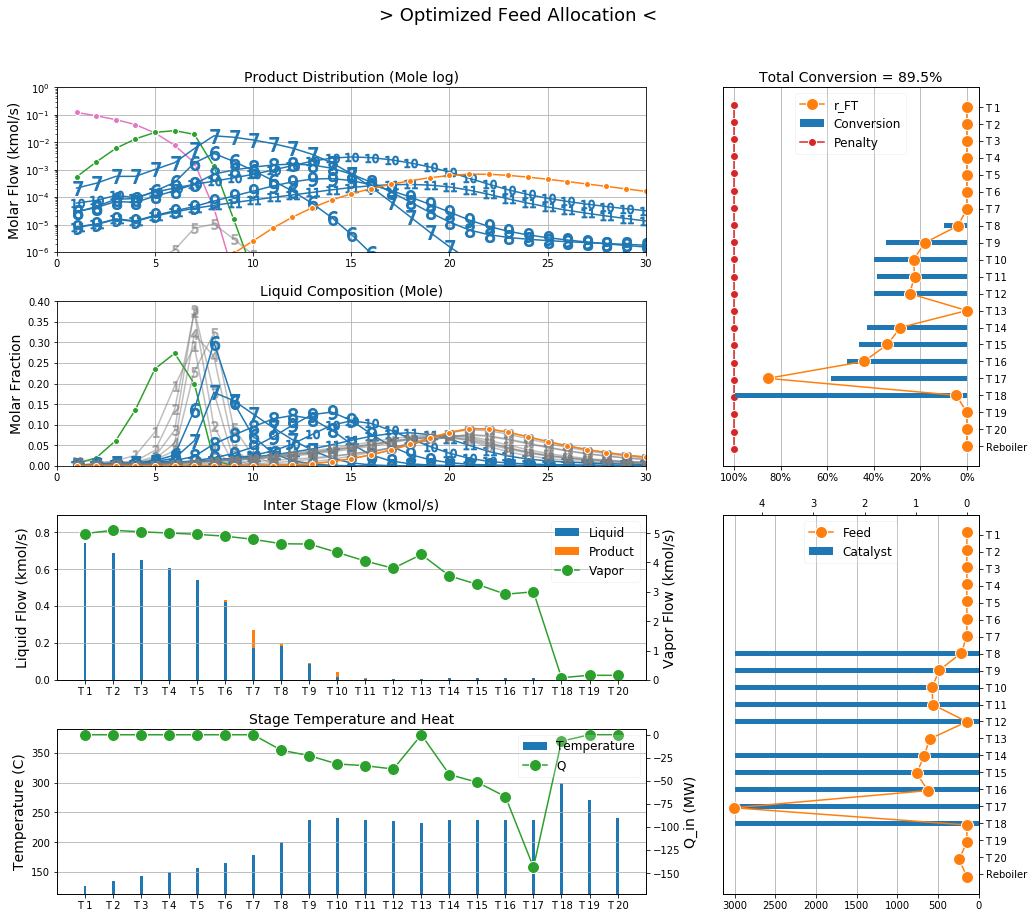

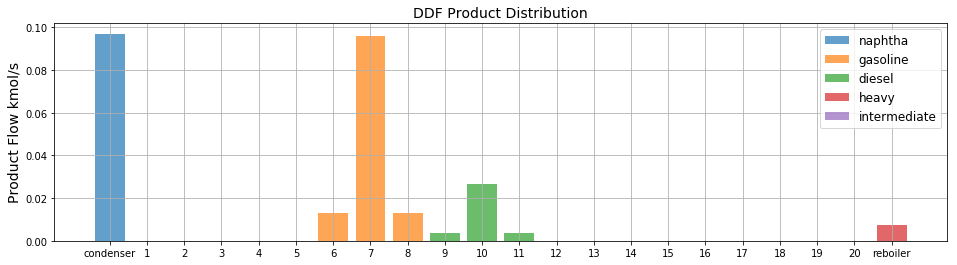

In [27]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Allocation')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Allocation')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [28]:
# for j in model.TRAY_reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(10)
#     model.reactive[j].cat.setub(30000)

In [29]:
# model.total_cat_con = pe.ConstraintList()
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [30]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [31]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
# plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [32]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [33]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.46%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -146.                                        1.8299          0.5656  0.0914       2.4200

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.8  0.000       0.000  0.000  0.000  0.000       4.9070  0.0000  0.6543  0.0000       20.000
NON--[2]     131.5  0.000       0.000  0.000  0.000  0.000       4.9957  0.0000  0.5961  0.0000       20.000
NON--[3]     139.3  0.000       0.000  0.000  0.000  0.000       4.9375  0.0000  0.5469  0.0000       20.000
NON--[4]     147.2  0.000       0.000  0.000  0.

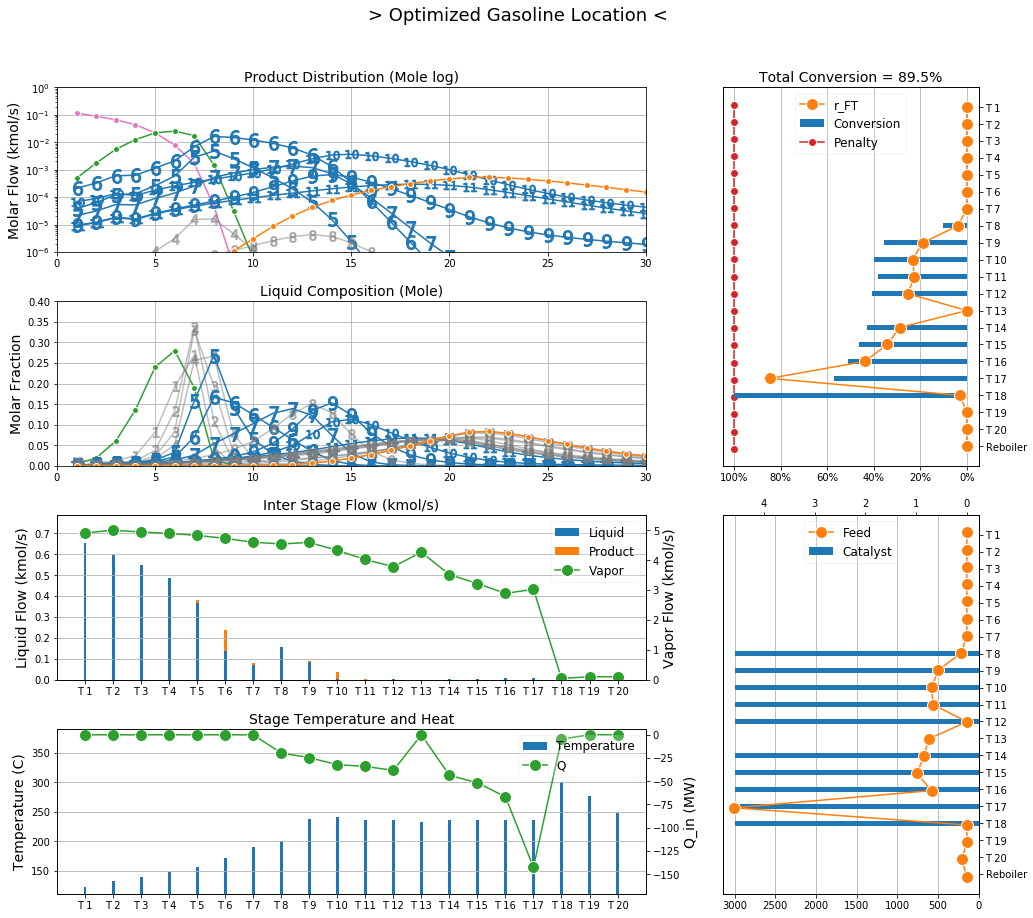

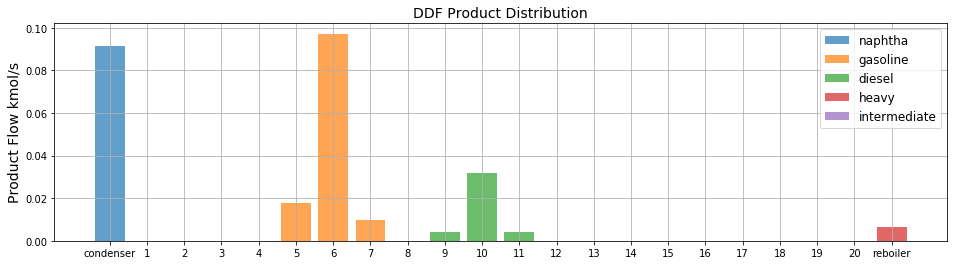

In [34]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [35]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(19)

In [36]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2739990e-01 2.36e-03 2.77e+00  -6.0 1.15e+01    -  7.96e-01 1.00e+00f  1
  66 -1.2742144e-01 5.05e-03 4.29e-02  -6.0 1.68e+01    -  1.00e+00 1.00e+00h  1
  67 -1.2742060e-01 2.36e-05 7.55e-04  -6.0 1.15e+00    -  1.00e+00 1.00e+00h  1
  68 -1.2742044e-01 2.79e-07 2.50e-06  -6.0 1.25e-01    -  1.00e+00 1.00e+00h  1
  69 -1.2768185e-01 2.38e-01 1.41e+02  -9.0 3.11e+02    -  1.34e-01 4.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2783606e-01 1.81e+00 1.53e+02  -9.0 6.28e+02    -  1.42e-01 3.43e-01h  1
  71 -1.2790096e-01 1.72e+00 1.35e+02  -9.0 2.45e+03    -  1.18e-01 8.92e-02h  1
  72 -1.2802175e-01 3.96e+00 9.06e+01  -9.0 1.31e+03    -  3.40e-01 3.52e-01h  1
  73 -1.2805180e-01 3.72e+00 6.10e+01  -9.0 2.16e+03    -  3.48e-01 8.36e-02h  1
  74 -1.2818668e-01 1.16e+01 3.88e+01  -9.0 2.35e+03    -  3.83e-01 3.73e-01h  1
  75 -1.2818810e-01 1.16e+01 3.87e+01  -9.0 3.38e+03    -  1.25e-05 3.37e-03h  1
  76 -1.2836369e-01 4.10e+01

 157 -1.2990812e-01 8.25e+00 2.67e+04  -9.0 1.26e+01  -6.1 4.07e-01 4.12e-02h  1
 158 -1.3002025e-01 7.87e+00 2.55e+04  -9.0 1.04e+02  -6.6 2.99e-02 4.54e-02h  1
Scaling factors are invalid - setting them all to 1.
 159 -1.3002889e-01 7.54e+00 2.45e+04  -9.0 9.11e+00  -6.2 4.71e-01 4.20e-02h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.3008623e-01 6.40e+00 2.08e+04  -9.0 1.61e+01  -6.7 4.82e-01 1.52e-01h  1
Scaling factors are invalid - setting them all to 1.
 161r-1.3008623e-01 6.40e+00 9.99e+02   0.6 0.00e+00  -7.1 0.00e+00 3.70e-08R  2
 162r-1.3008637e-01 6.40e+00 5.73e+03   0.6 3.40e+08    -  2.23e-12 2.79e-13f  1
 163 -1.3010744e-01 6.40e+00 1.07e+02  -9.0 4.01e+05    -  9.39e-04 5.46e-05h  1
 164 -1.3012129e-01 6.38e+00 1.06e+02  -9.0 7.38e+04    -  6.77e-03 3.45e-03h  1
 165 -1.3015341e-01 8.55e+00 1.06e+02  -9.0 5.43e+05    -  1.09e-07 6.33e-04h  1
In iteration 165, 1 Slack too s

Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 242 -1.3244857e-01 5.46e+01 4.98e+01  -9.0 1.09e+03  -0.9 4.92e-11 1.47e-05h  1
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 243 -1.3244842e-01 5.46e+01 4.98e+01  -9.0 1.18e+01  -1.4 2.61e-05 7.43e-05h  2
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 244 -1.3244835e-01 5.46e+01 4.98e+01  -9.0 1.16e+01  -1.9 7.44e-05 3.22e-05h  5
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 245 -1.3244832e-01 5.46e+01 4.98e+01  -9.0 1.14e+01  -2.3 1.01e-04 1.28e-05h  7
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 246 -1.3244786e-01 5.46e+01 4.98e+01  -9.0 9.46e+00  -2.8 2.12e-04 2.12e-04s 12
Scaling factors are invalid - setting them all to 1.
Scaling fact

 312 -1.3195603e-01 1.81e-04 3.40e+01  -9.0 2.21e-01  -4.6 8.15e-05 1.00e+00h  1
 313 -1.3195598e-01 1.15e-05 3.01e+00  -9.0 2.15e-02  -5.1 1.62e-01 9.88e-01h  1
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 314 -1.3195598e-01 1.16e-05 2.47e+00  -9.0 8.36e-05  -1.0 1.00e+00 1.87e-01f  2
 315 -1.3195598e-01 5.01e-06 1.17e+00  -9.0 4.91e-05  -1.5 1.00e+00 5.42e-01h  1
Scaling factors are invalid - setting them all to 1.
 316 -1.3195598e-01 3.16e-06 7.79e-01  -9.0 3.67e-04  -2.0 1.00e+00 4.15e-01f  2
Scaling factors are invalid - setting them all to 1.
 317 -1.3195598e-01 2.84e-10 3.57e-03  -9.0 3.48e-04  -2.5 1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting

 392 -1.3197194e-01 3.57e-03 3.99e-02  -9.0 1.76e+01  -8.9 1.00e+00 1.00e+00f  1
Scaling factors are invalid - setting them all to 1.
 393 -1.3197187e-01 2.13e-03 2.74e-02  -9.0 9.67e+00  -9.4 1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 394 -1.3197181e-01 5.29e-06 1.78e-03  -9.0 1.12e+01  -9.9 1.00e+00 1.00e+00H  1
Scaling factors are invalid - setting them all to 1.
 395 -1.3197185e-01 4.31e-05 9.52e-04  -9.0 3.28e+01 -10.4 1.00e+00 1.00e+00H  1
Scaling factors are invalid - setting them all to 1.
 396 -1.3197198e-01 1.31e-01 5.42e-03  -9.0 1.02e+02 -10.9 1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 397 -1.3197222e-01 4.36e-01 2.15e-02  -9.0 3.48e+02 -11.3 5.17e-01 5.12e-01h  1
Scaling factors are invalid - setting them all to 1.
 398 -1.3197219e-01 2.47e-01 1.32e-01  -9.0 5.88e+01    -  2.51e-01 4.52e-01h  1
 399 -1.3197254e-01 1.69e+00 1.34e-01  -9.0 4.11e+03 -11.8 9.26e-02 8.59e-02h  1
iter    objective    inf_pr   inf_

Scaling factors are invalid - setting them all to 1.
 461 -1.3197300e-01 3.01e-07 5.66e-04  -9.0 1.62e-01    -  1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 462 -1.3197300e-01 2.01e-07 6.31e-04  -9.0 1.32e-01    -  1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 463 -1.3197300e-01 1.10e-08 4.51e-05  -9.0 3.09e-02    -  1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 464 -1.3197300e-01 8.19e-10 5.06e-06  -9.0 8.53e-03    -  1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 465 -1.3197300e-01 3.05e-10 2.80e-11  -9.0 2.99e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 465

                                   (scaled)                 (unscaled)
Objective...............:  -1.3197299747472577e-01   -1.3197299747472577e-01
Dual infeasibility......:   2.7980645578296048e-11    2.7980645578296048e-11
Constraint violation....:   3.0548364901052116e-10    3.0548364901052116e


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.68%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        1.7964          0.6131  0.0891       2.4372

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.8  0.000       0.000  0.000  0.000  0.000       4.9359  0.0000  0.7135  0.0000       20.000
NON--[2]     131.3  0.000       0.000  0.000  0.000  0.000       5.0363  0.0000  0.6535  0.0000       20.000
NON--[3]     139.1  0.000       0.000  0.000  0.000  0.000       4.9763  0.0000  0.6027  0.0000       20.000
NON--[4]     147.2  0.000       0.000  0.000  0.00

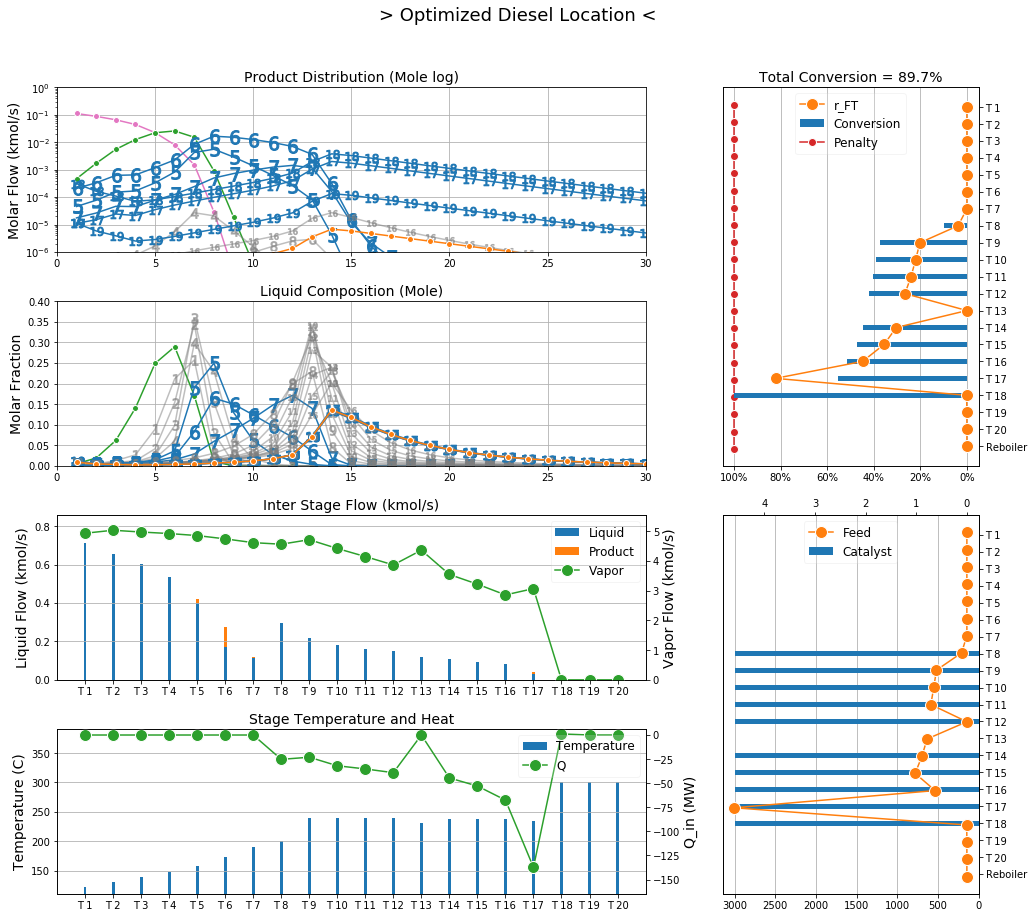

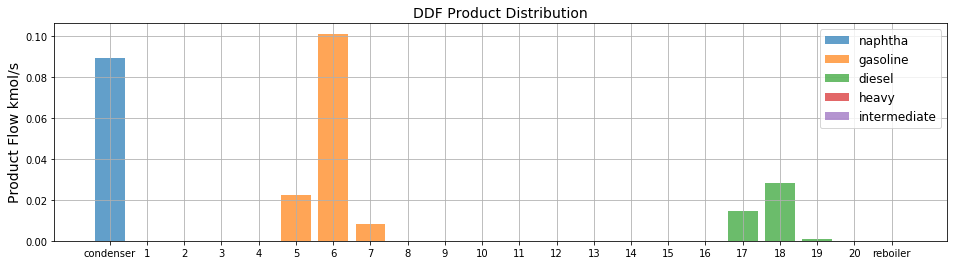

In [37]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [38]:
pdf.close()

In [39]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [40]:
model.P_tray.pprint()

P_tray : Size=110, Index=P_tray_index
    Key                           : Lower : Value                  : Upper : Fixed : Stale : Domain
                  ('1', 'diesel') : 1e-05 :                  1e-05 :  None : False : False : NonNegativeReals
                ('1', 'gasoline') : 1e-05 :                  1e-05 :  None : False : False : NonNegativeReals
                   ('1', 'heavy') :     0 :                  1e-05 :  None :  True :  True : NonNegativeReals
            ('1', 'intermediate') : 1e-05 :                  1e-05 :  None : False : False : NonNegativeReals
                 ('1', 'naphtha') :     0 :                  1e-05 :  None :  True :  True : NonNegativeReals
                 ('10', 'diesel') : 1e-05 :                  1e-05 :  None : False : False : NonNegativeReals
               ('10', 'gasoline') : 1e-05 : 1.0000000000179316e-05 :  None : False : False : NonNegativeReals
                  ('10', 'heavy') :     0 :                  1e-05 :  None :  True :  True :